# Aprendizaje de Máquina con Big Data y Apache Spark
## Exploración y preparación de los datos
![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

Para el procesamiento de Big Data utilizando Ciencia de Datos/Analítica de Datos/Aprendizaje de Máquina, existe una metodología ampliamente utilizada en la industria conocida como CRISP-DM creada por IBM, el siguiente diagrama representa la secuencia de pasos correspondientes a esta metodología:

![CRISP-DM](https://www.ibm.com/docs/es/SS3RA7_sub/modeler_crispdm_ddita/clementine/images/crisp_process.jpg)

En este diagrama se identifican las siguientes etapas:

1. Entendimiento del negocio (objetivos)
2. Exploración de los datos
3. Preparación de los datos
4. Modelado
5. Evaluación
6. Despliegue

El cual representa un proceso iterativo, que comienza con el entendimiento del negocio y termina, y vuelve a comenzar, con la evaluación de resultados.

Este notebook está inspirado en el capítulo 2 del libro [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb)

## Descripción del problema

Usted es el científico de datos de una empresa de bienes raíces en el estado de California de los Estados Unidos de América. Desde hace un tiempo, se ha identificado una gran dificultad a la hora de asignar un precio acertado a una propiedad para ponerla en el mercado, aumentando en gran medida el tiempo que le toma a un agente concretar la venta de la propiedad. En la mayoría de los casos, se ha evidenciado que el precio inicial está por encima del precio real de mercado, lo que hace la propiedad poco atractiva para los compradores; aunque tampoco se descarta que para algunas propiedades se haya listado un precio menor al del mercado, reduciendo el beneficio económico de la compañia y los agentes de venta.

En este panorama, se le ha asignado la tarea de predecir el valor promedio de las propiedades en el estado de California a partir de un [conjunto de datos](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) con características relevantes.

### Configuración del ambiente de Google Colaboratory

In [1]:
# Descargar Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# A continuación, instalaremos Apache Spark 3.0.1 con Hadoop 2.7 desde aquí.
!wget https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
# Ahora, sólo tenemos que descomprimir esa carpeta.
!tar xf spark-3.5.1-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"
# Instalación de los paquetes necesarios
!pip install pyspark==3.5.1
!pip install findspark

--2024-07-31 23:30:08--  https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400446614 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.1-bin-hadoop3.tgz’

spark-3.5.1-bin-had 100%[===================>] 381.90M   230MB/s    in 1.7s    

2024-07-31 23:30:10 (230 MB/s) - ‘spark-3.5.1-bin-hadoop3.tgz’ saved [400446614/400446614]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=2bfdb48ab300adfb5d4748203931805cc9ac666f8b9ecd23ffc87c749d4e3b01
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import os
import tarfile
import urllib.request
from pathlib import Path

def fetch_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")

fetch_housing_data()

In [3]:
import datetime as dt
import findspark
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.ml as ml
from pyspark.sql import functions as fct
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType

findspark.init()

### Crear Sesión de Spark e importar los datos

In [4]:
ss = (SparkSession
      .builder
      .appName("data_exploration_preparation")
      .getOrCreate())

In [5]:
path = "/content/datasets/housing/housing.csv"
housing_data = ss.read.csv(path, inferSchema=True, header=True)

In [6]:
housing_data.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

### División en el conjunto de entrenamiento y conjunto de evaluación

In [7]:
train_size = 0.7 # Tamaño del conjunto de entrenamiento: 70%
test_size = 0.3 # Tamaño del conjunto de evaluación: 30%
housing_data_train, housing_data_test = housing_data.randomSplit([train_size, test_size], seed=42)
housing_data_pd = housing_data_train.toPandas() # Convertirlo a un DataFrame de pandas para generar visualizaciones

### Exploración de los datos

In [8]:
housing_data_train.printSchema() # Esquema relacional del conjunto de datos

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [9]:
housing_data_train.show(10) # Primeros 10 registros del conjunto de datos

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|           94600.0|     NEAR OCEAN|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797|           85800.0|     NEAR OCEAN|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|     NEAR OCEAN|
|  -124.26|   40.58|              52.0|     2217.0|         394.0|     907.0|     369.0|       2.3571|          111400.0|     NEAR OCEAN|
|  -124.25|   40.28|              

In [10]:
(housing_data_train
 .describe() # Características estadísticas básicas
 .show())

+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+---------------+
|summary|          longitude|          latitude|housing_median_age|      total_rooms|   total_bedrooms|        population|        households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+---------------+
|  count|              14509|             14509|             14509|            14509|            14368|             14509|             14509|             14509|             14509|          14509|
|   mean|-119.59274932800152|35.660388724240136|28.668137018402373|2615.102212419877|534.5634047884187|1415.5490385278104|496.75215383555036|3.8453705562065017|205580.80998001242|           NULL|
| stddev| 2.01013816

In [11]:
housing_data_train.count() # Número de registros

14509

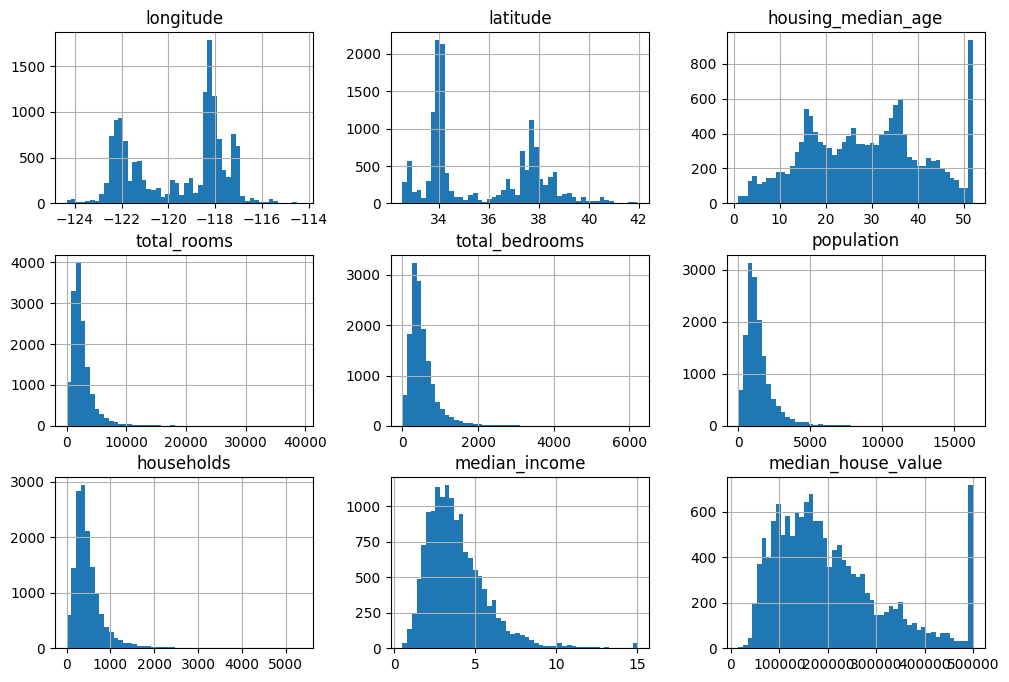

In [12]:
housing_data_pd.hist(bins=50, figsize=(12, 8)) # Calcular y graficar el histograma de cada característica
plt.show()

Acerca del histograma:
- Los ingresos no están representados en dólares (USD), están representados como un valor flotante entre ≃0.5 y ≃15. Al consultar con el equipo que recolectó los datos, este valor está expresado en decenas de miles de dólares, es decir, 3 corresponde a ingresos de aproximadamente \$30.000 USD.
- Los precios de las propiedades tienen un límite artificial de \$500.000 USD, lo cual puede generar comportamientos indeseados en el modelo, que podría "entender" este comportamiento como que no hay propiedades de un mayor valor.
- Las distribuciones de la mayoría de las características son asimétricas y no corresponden con una distribución Gaussiana, lo que puede tener un impacto negativo en el desempeño de algunos modelos.
- Las características están representadas en escalas y rangos muy diferentes.

#### Datos geoespaciales

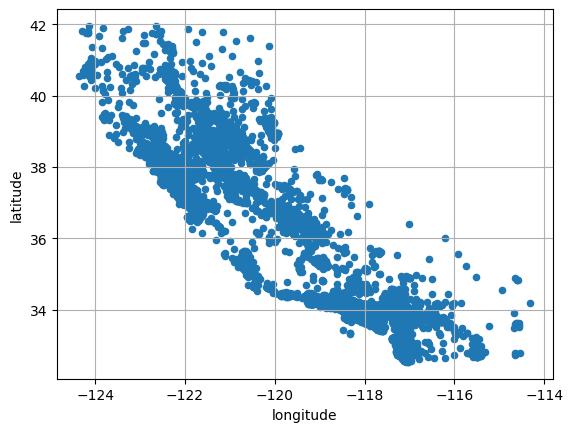

In [13]:
housing_data_pd.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

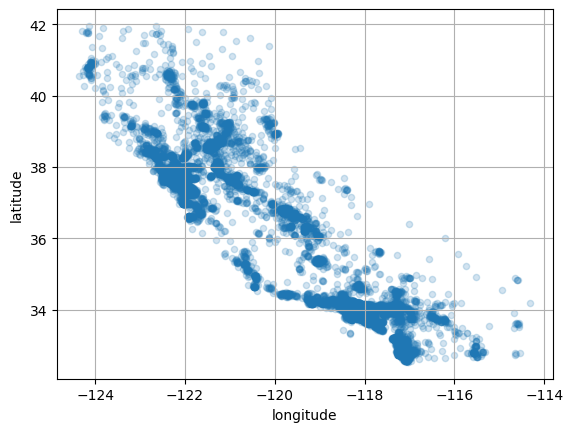

In [14]:
housing_data_pd.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

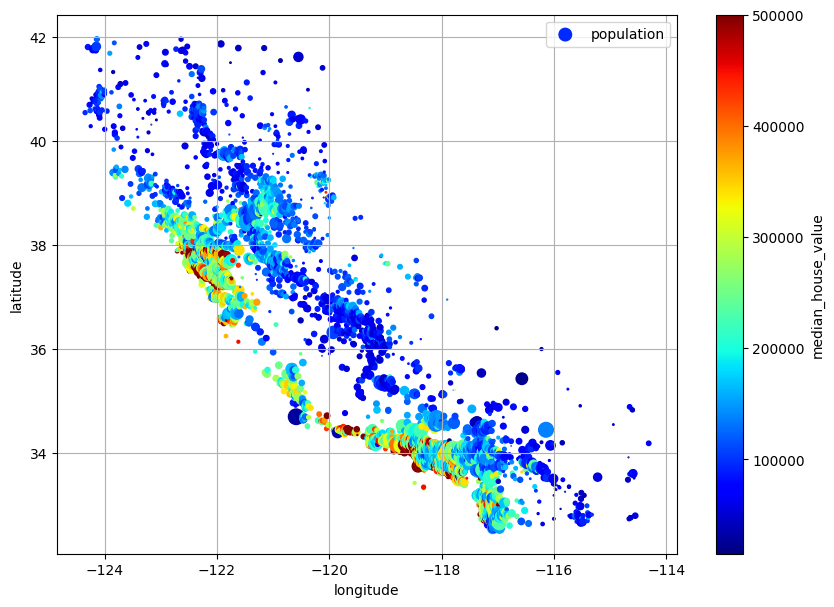

In [15]:
housing_data_pd.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                     s=housing_data_pd["population"] / 100, label="population",
                     c="median_house_value", cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.show()

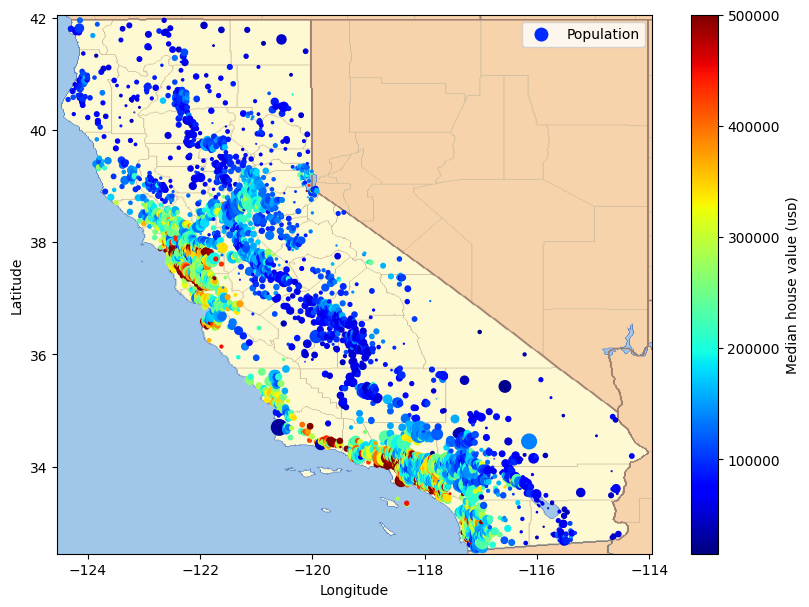

In [16]:
filename = "california.png"
homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
url = homl3_root + "images/end_to_end_project/" + filename
print("Downloading", filename)
urllib.request.urlretrieve(url, filename)

housing_renamed = housing_data_pd.rename(columns={"latitude": "Latitude", "longitude": "Longitude",
                                                  "population": "Population",
                                                  "median_house_value": "Median house value (ᴜsᴅ)"})

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude",
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

#### Correlaciones
La correlación es una medida estadística que expresa hasta qué punto dos variables están relacionadas linealmente (esto es, cambian conjuntamente a una tasa constante). Es una herramienta común para describir relaciones simples sin hacer afirmaciones sobre causa y efecto [[ref](https://www.jmp.com/es_co/statistics-knowledge-portal/what-is-correlation.html)].

In [17]:
cols = housing_data_train.columns
target_col = "median_house_value"
cols.remove("ocean_proximity")
cols.remove(target_col)
print("Correlación entre las variables: ")
for col in cols:
  print(f"{target_col} - {col}: {housing_data_train.corr(target_col, col)}")

Correlación entre las variables: 
median_house_value - longitude: -0.048734489520877715
median_house_value - latitude: -0.14166014521476414
median_house_value - housing_median_age: 0.10585697542376424
median_house_value - total_rooms: 0.13932642838983347
median_house_value - total_bedrooms: 0.056133897510110844
median_house_value - population: -0.02148680786679524
median_house_value - households: 0.07041591413437558
median_house_value - median_income: 0.6836796788520056


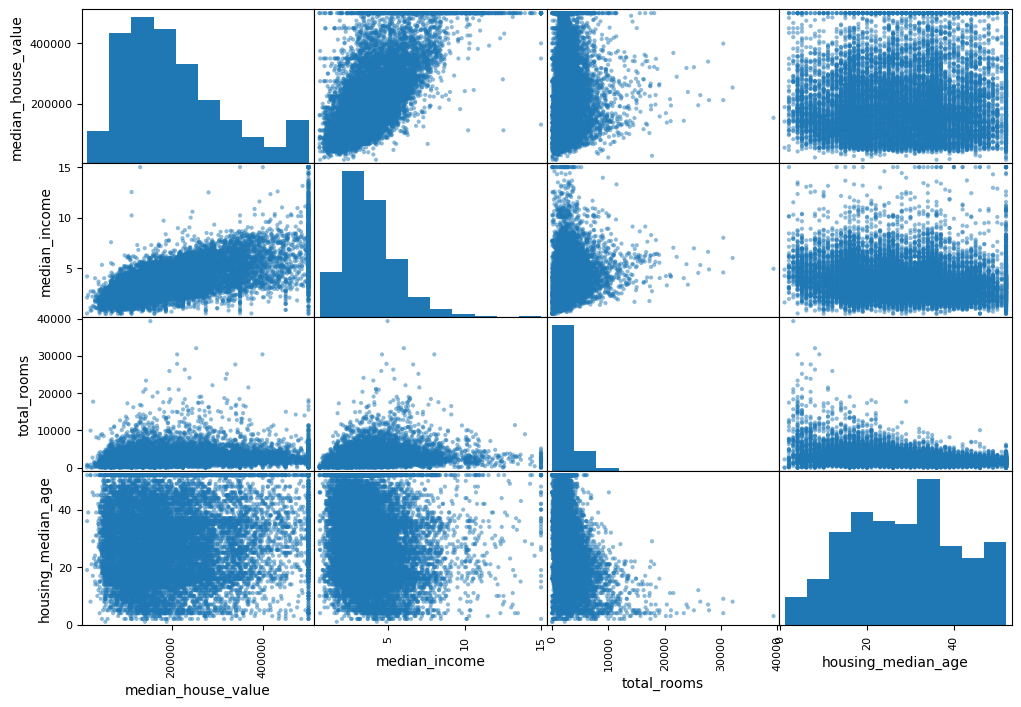

In [18]:
caracteristicas = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(housing_data_pd[caracteristicas], figsize=(12, 8))
plt.show()

La variable de mayor correlación con nuestra caractarística objetivo (*median_house_value*) es *median_income*. Fijándonos en el gráfico entre estas dos características evidenciamos una tendencia clara "hacia arriba" y poca dispersión entre los puntos.

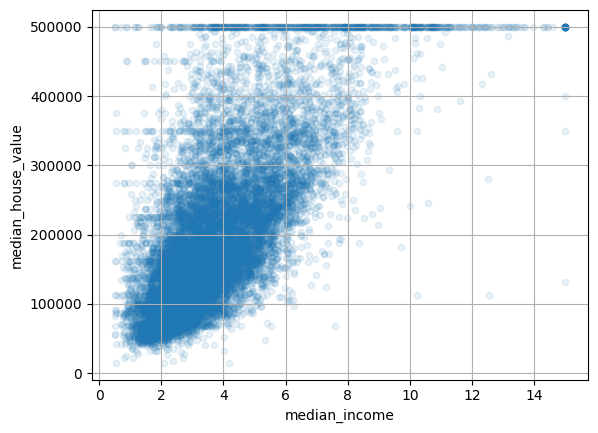

In [19]:
housing_data_pd.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

### Creación de nuevos atributos

In [20]:
housing_data_train2 = (housing_data_train
                      .withColumn("rooms_per_household", housing_data_train["total_rooms"]/housing_data_train["households"])
                      .withColumn("bedrooms_per_room", housing_data_train["total_bedrooms"]/housing_data_train["total_rooms"])
                      .withColumn("population_per_household", housing_data_train["population"]/housing_data_train["households"]))

In [21]:
new_cols = ["rooms_per_household", "bedrooms_per_room", "population_per_household"]
for col in new_cols:
  print(f"{target_col} - {col}: {housing_data_train2.corr(target_col, col)}")

median_house_value - rooms_per_household: 0.14836664719672774
median_house_value - bedrooms_per_room: -0.23387759463876323
median_house_value - population_per_household: -0.03004164488595351


### Preparación de los datos

#### Separación de características/predictores y etiquetas

In [22]:
X_train = housing_data_train.drop("median_house_value")
y_train = housing_data_train.select("median_house_value")

X_test = housing_data_test.drop("median_house_value")
y_test = housing_data_test.select("median_house_value")

#### Tratamiento de datos nulos

In [23]:
(X_train
 .describe()
 .show())

+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+---------------+
|summary|          longitude|          latitude|housing_median_age|      total_rooms|   total_bedrooms|        population|        households|     median_income|ocean_proximity|
+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+---------------+
|  count|              14509|             14509|             14509|            14509|            14368|             14509|             14509|             14509|          14509|
|   mean|-119.59274932800152|35.660388724240136|28.668137018402373|2615.102212419877|534.5634047884187|1415.5490385278104|496.75215383555036|3.8453705562065017|           NULL|
| stddev| 2.0101381627905033|2.1443786967346115|12.563856962511244|2142.945353240265|415.2139447434203|1081.0649459

Opción 1: descartar los registros con datos nulos

In [24]:
X_train_valid = X_train.dropna(how = "any", subset = ["total_bedrooms"])
X_train_valid.count()

14368

Opción 2: descartar el atributo

In [25]:
X_train_ = X_train.drop("total_bedrooms")
print(X_train_.count())
print(X_train.columns)

14509
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']


Opción 3: al ser una característica numérica, se pueden reemplazar los valores faltantes con alguna medida estadística de esa característica.

In [26]:
imputer = (ml.feature.Imputer()
.setStrategy("median")
.setInputCols(["total_bedrooms"])
.setOutputCols(["total_bedrooms_complete"]))
model = imputer.fit(X_train)
model.surrogateDF.show()

+--------------+
|total_bedrooms|
+--------------+
|         433.0|
+--------------+



In [27]:
X_train_median = model.transform(X_train)
X_train_median.count()

14509

#### Características categóricas
De manera general, los modelos o algoritmos de aprendizaje de máquina solo pueden ser entrenados con características numéricas. Las características de texto o categóricas deben ser convertidas a una representación numérica.

In [28]:
X_train.select("ocean_proximity").show(5)

+---------------+
|ocean_proximity|
+---------------+
|     NEAR OCEAN|
|     NEAR OCEAN|
|     NEAR OCEAN|
|     NEAR OCEAN|
|     NEAR OCEAN|
+---------------+
only showing top 5 rows



In [ ]:
unique_ocean_prox = (X_train
                     .select("ocean_proximity")
                     .dropDuplicates()
                     .collect())
unique_ocean_prox = [item.ocean_proximity for item in unique_ocean_prox]
print(unique_ocean_prox)

['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND']


Opción 1: reemplazar los valores con un número entero

In [ ]:
map_dict = {item: i for i, item in enumerate(unique_ocean_prox)}
print(map_dict)

{'ISLAND': 0, 'NEAR OCEAN': 1, 'NEAR BAY': 2, '<1H OCEAN': 3, 'INLAND': 4}


In [ ]:
stringIndexer = ml.feature.StringIndexer(inputCol="ocean_proximity", outputCol="ordinal_ocean_proximity", stringOrderType="frequencyDesc")
stringIndexer.setHandleInvalid("error")
model = stringIndexer.fit(X_train)

In [ ]:
X_train_ordinal = model.transform(X_train).drop("ocean_proximity")
X_train_ordinal.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ordinal_ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|                    2.0|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797|                    2.0|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|                    2.0|
|  -124.26|   40.58|              52.0|     2217.0|         394.0|     907.0|     369.0|       2.3571|                    2.0|
|  -124.25|   40.28|              32.0|     1430.0|         419.0|     434.0|     187.0|       1.9417|         

Opción 2: One-hot encoding

Esta segunda opción busca evitar un problema que se presenta con la opción 1 que es la de asignar implícitamente una jerarquía u orden a nuestra variable categórica, lo que en muchas ocasiones no representa la realidad.

In [ ]:
@fct.udf(returnType=StringType())
def one_hot_encoding(x, map_dict = map_dict):
  values = list(map_dict.keys())
  one_hot_vector = np.zeros(len(values), dtype=np.uint8)
  one_hot_vector[map_dict.get(x)] = 1
  return ','.join([str(i) for i in one_hot_vector])

In [ ]:
(X_train
 .withColumn("onehot_ocean_proximity", one_hot_encoding(X_train.ocean_proximity))
 .withColumn("onehot_ocean_ISLAND", fct.split("onehot_ocean_proximity", ",").getItem(0))
 .withColumn("onehot_ocean_NEAR_OCEAN", fct.split("onehot_ocean_proximity", ",").getItem(1))
 .withColumn("onehot_ocean_NEAR_BAY", fct.split("onehot_ocean_proximity", ",").getItem(2))
 .withColumn("onehot_ocean_1H_OCEAN", fct.split("onehot_ocean_proximity", ",").getItem(3))
 .withColumn("onehot_ocean_INLAND", fct.split("onehot_ocean_proximity", ",").getItem(4))
 #.where("ocean_proximity = 'NEAR BAY'")
 .show())

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+----------------------+-------------------+-----------------------+---------------------+---------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ocean_proximity|onehot_ocean_proximity|onehot_ocean_ISLAND|onehot_ocean_NEAR_OCEAN|onehot_ocean_NEAR_BAY|onehot_ocean_1H_OCEAN|onehot_ocean_INLAND|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+----------------------+-------------------+-----------------------+---------------------+---------------------+-------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|     NEAR OCEAN|             0,1,0,0,0|                  0|                      1|                    0|                    0|                  0|


In [ ]:
onehotencoder = ml.feature.OneHotEncoder(inputCol="ordinal_ocean_proximity", outputCol="onehot_ocean_proximity")
onehotencoder.setHandleInvalid("error")
model = onehotencoder.fit(X_train_ordinal)

In [ ]:
X_train_onehot = model.transform(X_train_ordinal).drop("ordinal_ocean_proximity")
X_train_onehot.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|onehot_ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+----------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|         (4,[2],[1.0])|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797|         (4,[2],[1.0])|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|         (4,[2],[1.0])|
|  -124.26|   40.58|              52.0|     2217.0|         394.0|     907.0|     369.0|       2.3571|         (4,[2],[1.0])|
|  -124.25|   40.28|              32.0|     1430.0|         419.0|     434.0|     187.0|       1.9417|         (4,[2],

In [ ]:
X_train_onehot = (X_train
                  .withColumn("onehot_ocean_proximity", one_hot_encoding(X_train.ocean_proximity))
                  .withColumn("onehot_ocean_ISLAND", fct.split("onehot_ocean_proximity", ",").getItem(0).cast(IntegerType()))
                  .withColumn("onehot_ocean_NEAR_OCEAN", fct.split("onehot_ocean_proximity", ",").getItem(1).cast(IntegerType()))
                  .withColumn("onehot_ocean_NEAR_BAY", fct.split("onehot_ocean_proximity", ",").getItem(2).cast(IntegerType()))
                  .withColumn("onehot_ocean_1H_OCEAN", fct.split("onehot_ocean_proximity", ",").getItem(3).cast(IntegerType()))
                  .withColumn("onehot_ocean_INLAND", fct.split("onehot_ocean_proximity", ",").getItem(4).cast(IntegerType()))
                  .drop("ocean_proximity")
                  .drop("onehot_ocean_proximity"))
X_train_onehot.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-------------------+-----------------------+---------------------+---------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|onehot_ocean_ISLAND|onehot_ocean_NEAR_OCEAN|onehot_ocean_NEAR_BAY|onehot_ocean_1H_OCEAN|onehot_ocean_INLAND|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-------------------+-----------------------+---------------------+---------------------+-------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|                  0|                      1|                    0|                    0|                  0|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797|                  0|                      1|          

#### Normalización

In [ ]:
X_train_minmax_scaled = X_train_valid.alias("X_train_minmax_scaled")
numeric_cols = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income"]
vec_numeric_cols = ["vec_"+col for col in numeric_cols]
vecsAssembler = []
for in_col, out_col in zip(numeric_cols, vec_numeric_cols):
  vecAssembler = ml.feature.VectorAssembler(outputCol=out_col, inputCols=[in_col])
  X_train_minmax_scaled = vecAssembler.transform(X_train_minmax_scaled)
  vecsAssembler.append(vecAssembler)
X_train_minmax_scaled.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ocean_proximity|vec_longitude|vec_latitude|vec_housing_median_age|vec_total_rooms|vec_total_bedrooms|vec_population|vec_households|vec_median_income|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|     NEAR OCEAN|    [-124.35]|     [40.54]|                [52.0]|       [1820.0]|           [300.0]|       [806.0]|       [270.0]|         [3

In [ ]:
out_numeric_cols = ["scaled_"+col for col in numeric_cols]
minmaxScalers = []
for in_col, out_col in zip(vec_numeric_cols, out_numeric_cols):
  minmaxscaler = ml.feature.MinMaxScaler(outputCol=out_col, inputCol=in_col)
  model = minmaxscaler.fit(X_train_minmax_scaled)
  minmaxScalers.append(model)
  X_train_minmax_scaled = model.transform(X_train_minmax_scaled)
X_train_minmax_scaled.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-------------+------------+----------------------+---------------+------------------+--------------+--------------+-----------------+--------------------+--------------------+-------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ocean_proximity|vec_longitude|vec_latitude|vec_housing_median_age|vec_total_rooms|vec_total_bedrooms|vec_population|vec_households|vec_median_income|    scaled_longitude|     scaled_latitude|scaled_housing_median_age|  scaled_total_rooms|scaled_total_bedrooms|   scaled_population|   scaled_households|scaled_median_income|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-------------+------------+---

In [ ]:
X_train_minmax_scaled = X_train_minmax_scaled.select('scaled_longitude', 'scaled_latitude', 'scaled_housing_median_age',
                                              'scaled_total_rooms', 'scaled_total_bedrooms', 'scaled_population',
                                              'scaled_households', 'scaled_median_income')
X_train_minmax_scaled.show()

+--------------------+--------------------+-------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|    scaled_longitude|     scaled_latitude|scaled_housing_median_age|  scaled_total_rooms|scaled_total_bedrooms|   scaled_population|   scaled_households|scaled_median_income|
+--------------------+--------------------+-------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|               [0.0]|[0.8501594048884162]|                    [1.0]|[0.04623836410804...| [0.04815590272185...|[0.04925775978407...|[0.05021467239126...|[0.17343209059185...|
|[0.00498007968127...|[0.9840595111583416]|     [0.3529411764705882]|[0.0679078284755074]| [0.08874214849412...|[0.07943810575389...|[0.08904237446331...|[0.10205376477565...|
|[0.00796812749003...|[0.8660998937300739]|     [0.6862745098039216]|[0.05969276158502...| [0.08487679175390...|[0.07305

#### Creación del Pipeline (Secuencia de operaciones)

<!--

sqlTrans = ml.feature.SQLTransformer(statement="SELECT scaled_longitude AS longitude, \
                                                       scaled_latitude AS latitude, \
                                                       scaled_housing_median_age AS housing_median_age, \
                                                       scaled_total_rooms AS total_rooms, \
                                                       scaled_total_bedrooms_complete AS total_bedrooms, \
                                                       scaled_population AS population, \
                                                       scaled_households AS households, \
                                                       scaled_median_income AS median_income, \
                                                       onehot_ocean_proximity AS ocean_proximity, \
                                                       features, \
                                                       median_house_value AS label FROM __THIS__")


-->

In [ ]:
imputer = ml.feature.Imputer(strategy="median",inputCols=["total_bedrooms"],outputCols=["total_bedrooms_complete"])

stringIndexer = ml.feature.StringIndexer(inputCol="ocean_proximity", outputCol="ordinal_ocean_proximity", stringOrderType="frequencyDesc")

onehotencoder = ml.feature.OneHotEncoder(inputCol="ordinal_ocean_proximity", outputCol="onehot_ocean_proximity")

columns_to_scale = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms_complete","population","households","median_income"]

assemblers = [ml.feature.VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale+["median_house_value"]]

scalers = [ml.feature.MinMaxScaler(inputCol=col + "_vec", outputCol="scaled_" + col) for col in columns_to_scale]

feature_assembler = ml.feature.VectorAssembler(inputCols=["scaled_" + col for col in columns_to_scale]+["onehot_ocean_proximity"], outputCol="features")

sqlTrans = ml.feature.SQLTransformer(statement="SELECT features, median_house_value_vec AS label FROM __THIS__")

preprocess_pipeline = ml.Pipeline(stages=[imputer, stringIndexer, onehotencoder]+assemblers+scalers+[feature_assembler, sqlTrans])

In [ ]:
pipeline_model = preprocess_pipeline.fit(housing_data_train)
pipeline_model.transform(housing_data_train).show()